# **TensorFlow-based SMS Spam Filter**

With mobile phones now becoming an integral part of life, communication occurs on a daily basis through SMS and email. However, the majority of these messages turn out to be spam and only a few are valid or critical. Scammers send such deceptive messages that they try to get people to reveal passwords, bank account numbers, or social security details. Once acquired, it could be used to hack into personal accounts like emails, bank systems, or any other such online services.

In this project, we shall design **deep learning models on TensorFlow** to efficiently and accurately detect SMS spam messages. We will also study the performance metrics of such models to compare and make judgment on their accuracy.

For this, we will be using the **SMS Spam Detection Dataset**, which contains SMS messages with their respective labels, categorizing them as either "Ham" or "Spam".






---



### **Implementation**
We will import all the required libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



---
Load the Dataset using pandas function .read_csv()


In [ ]:
# Reading the data
df = pd.read_csv("/content/spam.csv",encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN




---

As we can see that the dataset contains three unnamed columns with null values. So we drop those columns and rename the columns v1 and v2 to label and Text, respectively. Since the target variable is in string form, we will encode it numerically using pandas function .map().

In [ ]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()

,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0




---

Let’s visualize the distribution of Ham and Spam data.

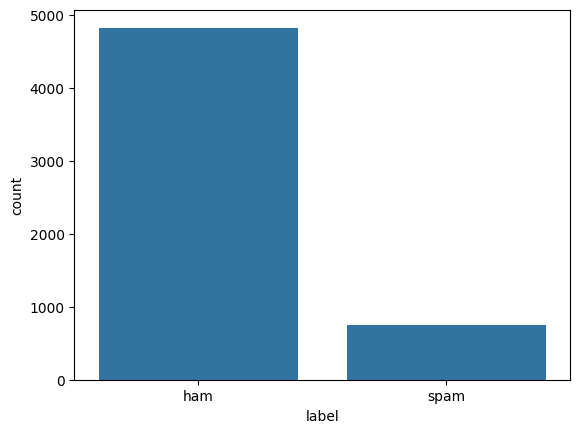

In [ ]:
sns.countplot(x=df['label'])
plt.show()



---

The ham data is comparatively higher than spam data, it’s natural. Since we are going to use embeddings in our deep learning model, we need not balance the data. Now, let’s find the average number of words in all the sentences in SMS data.

In [ ]:
# Find average number of tokens in all sentences
avg_words_len=round(sum([len(i.split()) for i in df['Text']])/len(df['Text']))
print(avg_words_len)

16




---

Now, let’s find the total number of unique words in the corpus

In [ ]:
# Finding Total no of unique words in corpus
s = set()
for sent in df['Text']:
  for word in sent.split():
    s.add(word)
total_words_length=len(s)
print(total_words_length)

15686




---

Now,  splitting the data into training and testing parts using train_test_split() function.

In [ ]:
# Splitting data for Training and testing
from sklearn.model_selection import train_test_split

X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
    new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4457,), (4457,), (1115,), (1115,))



---



### **Building the models**
First, we will build a baseline model and then we’ll try to beat the performance of the baseline model using deep learning models (embeddings, LSTM, etc)

Here, we will choose MultinomialNB(), which performs well for text classification when the features are discrete like word counts of the words or tf-idf vectors. The tf-idf is a measure that tells how important or relevant a word is the document.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)

baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)

MultinomialNB()



---

Performance of baseline model

In [ ]:
# Predicting the values
y_pred = baseline_model.predict(X_test_vec)

# Evaluating the model
print(classification_report(y_test,y_pred))
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy:", accuracy)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       1.00      0.72      0.84       149

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115

Accuracy: 0.9632286995515695




---

Confusion matrix for the baseline model

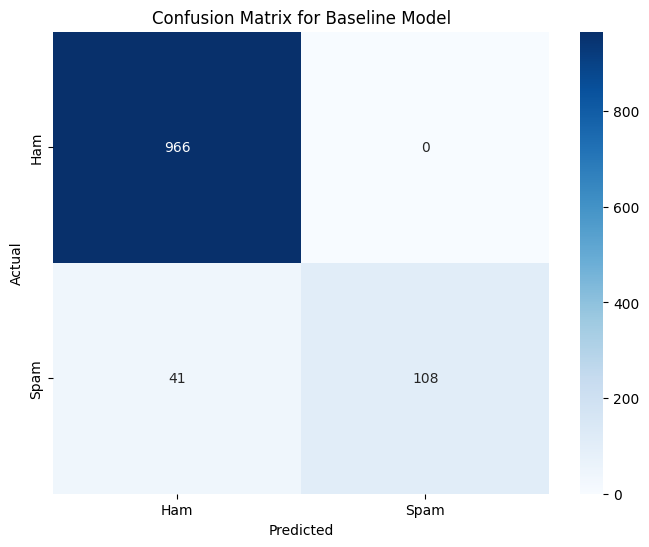

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined from the previous code

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Baseline Model')
plt.show()

### **Model 1: Creating custom Text vectorization and embedding layers:**
Text vectorization is the process of converting text into a numerical representation. Example: Bag of words frequency, Binary Term frequency, etc.;

A word embedding is a learned representation of text in which words with related meanings have similar representations. Each word is assigned to a single vector, and the vector values are learned like that of a neural network.

Now, we’ll create a custom text vectorization layer using TensorFlow.

In [ ]:
from tensorflow.keras.layers import TextVectorization

MAXTOKENS=total_words_length
OUTPUTLEN=avg_words_len

text_vec = TextVectorization(
    max_tokens=MAXTOKENS,
    standardize='lower_and_strip_punctuation',
    output_mode='int',
    output_sequence_length=OUTPUTLEN
)
text_vec.adapt(X_train)



---

Output of a sample sentence using text vectorization is shown below:

In [ ]:
# Sample sentence
sample_sentence = ["This is a message"]

# Vectorize the sample sentence using the trained text vectorization layer
vectorized_sentence = text_vec(sample_sentence)

# Print the vectorized output
vectorized_sentence

<tf.Tensor: shape=(1, 16), dtype=int64, numpy=
array([[ 41,  10,   5, 148,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0]])>



---

Now let’s create an embedding layer

* **input_dim** is the size of vocabulary
* **output_dim** is the dimension of the embedding layer i.e, the size of the vector in which the words will be embedded
* **input_length** is the length of input sequences

In [ ]:
embedding_layer = layers.Embedding(
    input_dim=MAXTOKENS,
    output_dim=128,
    embeddings_initializer='uniform',
    input_length=OUTPUTLEN
)

#Example usage
embedded_text = embedding_layer(vectorized_sentence)
embedded_text


<tf.Tensor: shape=(1, 16, 128), dtype=float32, numpy=
array([[[ 0.01446158,  0.01200416, -0.00573462, ..., -0.0112509 ,
         -0.03961341,  0.0254802 ],
        [-0.02551355,  0.01026388,  0.0361658 , ..., -0.00996941,
         -0.04506967, -0.04096454],
        [-0.03687534,  0.02837172, -0.04263423, ...,  0.02937733,
         -0.03442336,  0.01129924],
        ...,
        [-0.00780584, -0.0275437 , -0.00527172, ..., -0.04256592,
         -0.00360712,  0.03917689],
        [-0.00780584, -0.0275437 , -0.00527172, ..., -0.04256592,
         -0.00360712,  0.03917689],
        [-0.00780584, -0.0275437 , -0.00527172, ..., -0.04256592,
         -0.00360712,  0.03917689]]], dtype=float32)>



---

Now, let’s build and compile model 1 using the Tensorflow Functional API

In [ ]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)

model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(
    label_smoothing=0.5), metrics=['accuracy'])



---

Summary of the model 1

In [ ]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 16)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 16, 128)             │       2,007,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,035,909 (23.03 MB)

 Trainable params: 2,011,969 (7.68 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,023,940 (15.35 MB)



---


Training the model-1


In [ ]:
history_1 = model_1.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test), validation_steps=int(0.2*len(X_test)))

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9972 - loss: 0.5641 - val_accuracy: 0.9812 - val_loss: 0.5725
Epoch 2/5
138/140 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9972 - loss: 0.5640

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.9972 - loss: 0.5640
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9979 - loss: 0.5635 - val_accuracy: 0.9776 - val_loss: 0.5728
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9998 - loss: 0.5631
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9994 - loss: 0.5631 - val_accuracy: 0.9794 - val_loss: 0.5726




---


Plotting the history of model-1

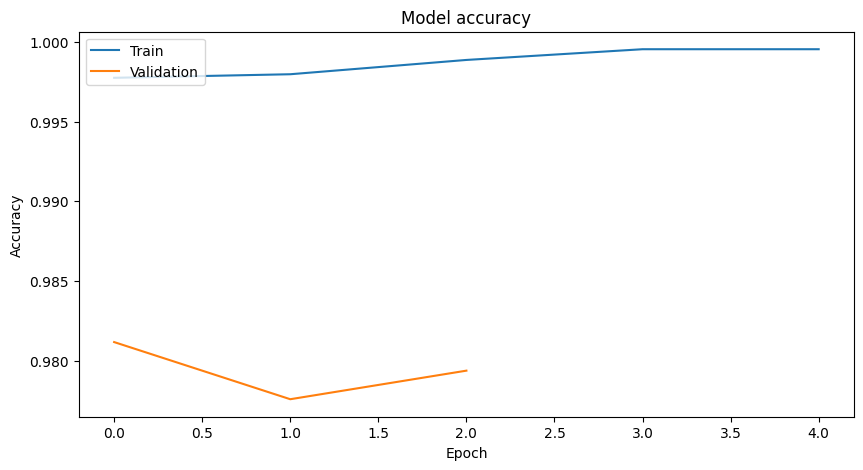

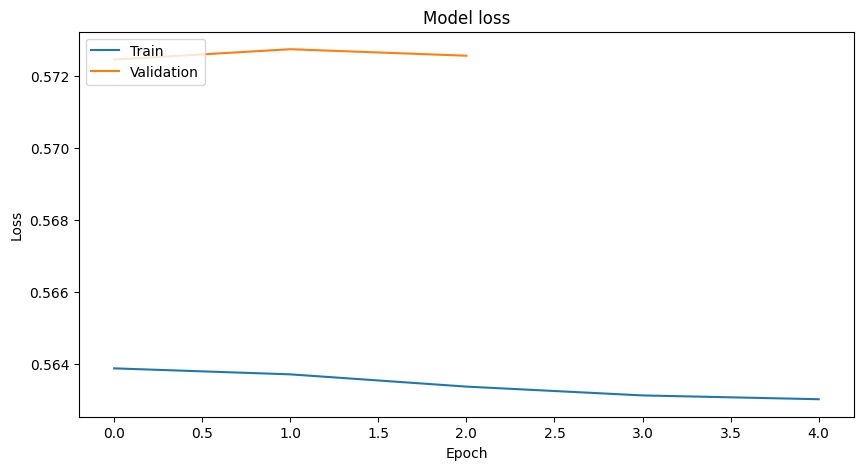

In [ ]:
import matplotlib.pyplot as plt

# Assuming history_1 is the training history object from model_1.fit
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()



---

Let’s create helper functions for compiling, fitting, and evaluating the model performance.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compile_model(model):
    '''
    simply compile the model with adam optimzer
    '''
    model.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

def evaluate_model(model, X, y):
    '''
    evaluate the model and returns accuracy,
    precision, recall and f1-score
    '''
    y_preds = np.round(model.predict(X))
    accuracy = accuracy_score(y, y_preds)
    precision = precision_score(y, y_preds)
    recall = recall_score(y, y_preds)
    f1 = f1_score(y, y_preds)

    model_results_dict = {'accuracy': accuracy,
                        'precision': precision,
                        'recall': recall,
                        'f1-score': f1}

    return model_results_dict

def fit_model(model, epochs, X_train=X_train, y_train=y_train,
            X_test=X_test, y_test=y_test):
  '''
  fit the model with given epochs, train
  and test data
  '''
  # Check if validation data is provided
  if X_test is not None and y_test is not None:
      history = model.fit(X_train,
                      y_train,
                      epochs=epochs,
                      validation_data=(X_test, y_test)) #Removed validation steps argument
  else:
      # Handle case where validation data is not provided
      history = model.fit(X_train,
                      y_train,
                      epochs=epochs)
  return history

# This code is modified by Susobhan Akhuli



---



### **Model -2 Bidirectional LSTM**
A bidirectional LSTM (Long short-term memory) is made up of two LSTMs, one accepting input in one direction and the other in the other. BiLSTMs effectively improve the network’s accessible information, boosting the context for the algorithm (e.g. knowing what words immediately follow and precede a word in a sentence).

**Building and compiling the model-2**

In [ ]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(
    64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)

compile_model(model_2) # compile the model
history_2 = fit_model(model_2, epochs=5, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test) # fit the model

# This code is modified by Susobhan Akhuli

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 70ms/step - accuracy: 0.8901 - loss: 0.3020 - val_accuracy: 0.9740 - val_loss: 0.0951
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.9869 - loss: 0.0387 - val_accuracy: 0.9812 - val_loss: 0.0705
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.9973 - loss: 0.0141 - val_accuracy: 0.9839 - val_loss: 0.0770
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.9984 - loss: 0.0056 - val_accuracy: 0.9812 - val_loss: 0.0960
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.9991 - loss: 0.0016 - val_accuracy: 0.9830 - val_loss: 0.1370




---

### **Model -3 Transfer Learning with USE Encoder**
<br>

**Transfer Learning**


Transfer learning is a machine learning approach in which a model generated for one job is utilized as the foundation for a model on a different task.
<br>
<br>
**USE Layer (Universal Sentence Encoder)**

The Universal Sentence Encoder converts text into high-dimensional vectors that may be used for text categorization, semantic similarity, and other natural language applications.
<br>
<br>

The USE can be downloaded from tensorflow_hub and can be used as a layer using **.kerasLayer()** function.

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Disable XLA compilation
tf.config.optimizer.set_jit(False)

# model with functional api
input_layer = keras.Input(shape=[], dtype=tf.string)

# universal-sentence-encoder layer
# directly from tfhub
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                        trainable=False,
                        input_shape=[],
                        dtype=tf.string,
                        name='USE')

# Create a Lambda layer to wrap the use_layer call
# Specify the output shape of the USE layer
x = layers.Lambda(lambda x: use_layer(x), output_shape=(512,))(input_layer)

x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation=keras.activations.relu)(x)
output_layer = layers.Dense(1, activation=keras.activations.sigmoid)(x)

model_3 = keras.Model(input_layer, output_layer)

compile_model(model_3)


history_3 = fit_model(model_3, epochs=5)

# This code is modified by Susobhan Akhuli

Epoch 1/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.8455 - loss: 0.4557 - val_accuracy: 0.9704 - val_loss: 0.1167
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9763 - loss: 0.0967 - val_accuracy: 0.9776 - val_loss: 0.0729
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9826 - loss: 0.0622 - val_accuracy: 0.9821 - val_loss: 0.0614
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9854 - loss: 0.0535 - val_accuracy: 0.9821 - val_loss: 0.0564
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9883 - loss: 0.0381 - val_accuracy: 0.9839 - val_loss: 0.0552




---



### **Analyzing our Model Performance**

We will use the helper function which we created earlier to evaluate model performance.

In [ ]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)
model_3_results = evaluate_model(model_3, X_test, y_test)

total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results,
                             'Custom-Vec-Embedding Model':model_1_results,
                             'Bidirectional-LSTM Model':model_2_results,
                             'USE-Transfer learning Model':model_3_results}).transpose()

total_results

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


,accuracy,precision,recall,f1-score
MultinomialNB Model,0.963229,1.000000,0.724832,0.840467
Custom-Vec-Embedding Model,0.979372,0.963235,0.879195,0.919298
Bidirectional-LSTM Model,0.982960,0.971014,0.899329,0.933798
USE-Transfer learning Model,0.983857,0.951724,0.926174,0.938776


from matplotlib import pyplot as plt
total_results['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
total_results['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
total_results['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
total_results['f1-score'].plot(kind='hist', bins=20, title='f1-score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
total_results.plot(kind='scatter', x='accuracy', y='precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
total_results.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
total_results.plot(kind='scatter', x='recall', y='f1-score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['accuracy']
  ys = series['precision']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = total_results.sort_values('accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('accuracy')
_ = plt.ylabel('precision')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['accuracy']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'accuracy'}, axis=1)
              .sort_values('accuracy', ascending=True))
  xs = counted['accuracy']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = total_results.sort_values('accuracy', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('accuracy')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['recall']
  ys = series['precision']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = total_results.sort_values('recall', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('recall')
_ = plt.ylabel('precision')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['recall']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'recall'}, axis=1)
              .sort_values('recall', ascending=True))
  xs = counted['recall']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = total_results.sort_values('recall', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('recall')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
total_results['accuracy'].plot(kind='line', figsize=(8, 4), title='accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
total_results['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
total_results['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
total_results['f1-score'].plot(kind='line', figsize=(8, 4), title='f1-score')
plt.gca().spines[['top', 'right']].set_visible(False)

### **Plotting the results**

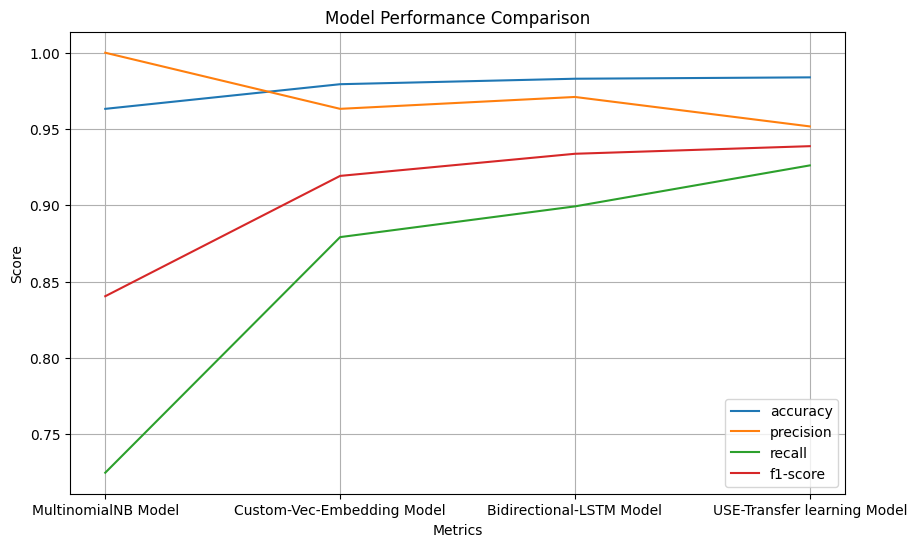

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'total_results' DataFrame is already created as in your provided code

plt.figure(figsize=(10, 6))
for column in total_results.columns:
    plt.plot(total_results.index, total_results[column], label=column)

plt.title('Model Performance Comparison')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()



---



### **Metrics**
All four models deliver excellent results. (All of them have greater than 96 percent accuracy), thus comparing them might be difficult.
<br>
<br>
### **Problem**
We have an unbalanced dataset; most of our data points contain the label “ham,” which is natural because most SMS are ham. Accuracy cannot be an appropriate metric in certain situations. Other measurements are required.
<br>
<br>
### **Which metric is better?**
* False negative and false positive are significant in this problem. Precision and recall are the metrics that allow us the ability to calculate them, but there is one more, ‘f1-score.’
* The f1-score is the harmonic mean of accuracy and recall. Thus, we can get both with a single shot.
* **USE-Transfer learning** model gives the best accuracy and f1-score.